# Real world example: GB1 landscape

In the previous tutorial, we have seen how to create a series of plots for the very simple case of the serine landscape that was artificially built for this purpose and had only 64 genotypes. Therefore, we knew beforehand the qualitative properties of the landscape, and saw how they were reflected on the visualization. However, we usually would want to do the opposite process, in which we visualize an unknown landscape and want to understand what are its main properties. 

In the followin tutorial we will show how to do that with a real world example using data from {cite}`Wu2016` 
for which we generated a visualization in previous work {cite}`Zhou2020c`. Now we can generate it and explore the different peaks in a few lines of python code.

As we have seen in previous notebooks, the visualizations can be easily created in few simple steps

1. Define the discrete sequence space describing the landscape
2. Define the random walk process on the discrete space
3. Calculate the visualization coordinates for every genotype
4. Plot the landscape

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import holoviews as hv

import gpmap.src.plot as plot

from gpmap.src.inference import VCregression
from gpmap.src.space import SequenceSpace
from gpmap.src.randwalk import WMWSWalk
from gpmap.src.genotypes import select_genotypes
from gpmap.src.seq import translate_seqs

In [3]:
data = pd.read_csv('gb1.data.csv', index_col=0)
space = SequenceSpace(seq_length=4, alphabet_type='protein', function=data['log_binding'].values)
rw = WMWSWalk(space)
rw.calc_visualization(mean_function=0)
nodes_df, edges_df = rw.nodes_df, rw.space.get_edges_df()

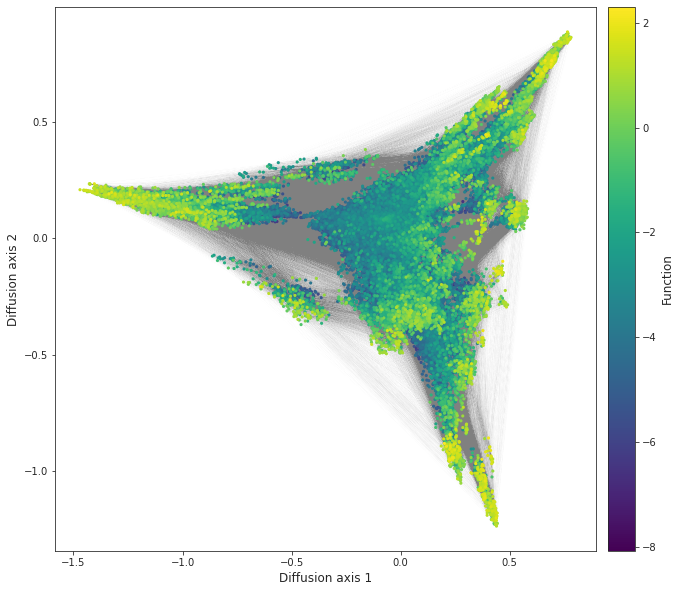

In [4]:
fig, axes = plot.init_fig(1, 1, figsize=(11, 10))
plot.plot_visualization(axes, nodes_df, edges_df=edges_df,
                        edges_alpha=0.005, ascending=True,
                        nodes_size=10)

# Visualize GB1 fitness landscape at the nucletide sequence

First, to reduce the computational complexity, we are going to use a reduced set of genotypes at the protein sequence to accelerate calculations. Previous results and visualizations suggests that the first two sites are fairly neutral. Thus, we are going to generate a modified landscape by marginalizing or averaging out the first position

In [11]:
data['genotype'] = [x[1:] for x in data.index]
df = data.groupby(['genotype'])[['log_binding']].mean()
df.head()

,log_binding
genotype,
AAA,-0.391702
AAC,-2.399389
AAD,-3.465397
AAE,-5.470245
AAF,-4.395685


In [13]:
space = SequenceSpace(seq_length=4, alphabet_type='protein',
                      function=data['log_binding'],
                      use_codon_model=True, codon_table='Standard',
                      stop_function=data['log_binding'].min())
rw = WMWSWalk(space)
rw.calc_visualization(mean_function=0)
nodes_df, edges_df = rw.nodes_df, rw.space.get_edges_df()

In [21]:
plot.plot_holoview(nodes_df, edges_df=edges_df,
                   nodes_color='function', x='2', y='1')

:DynamicMap   []

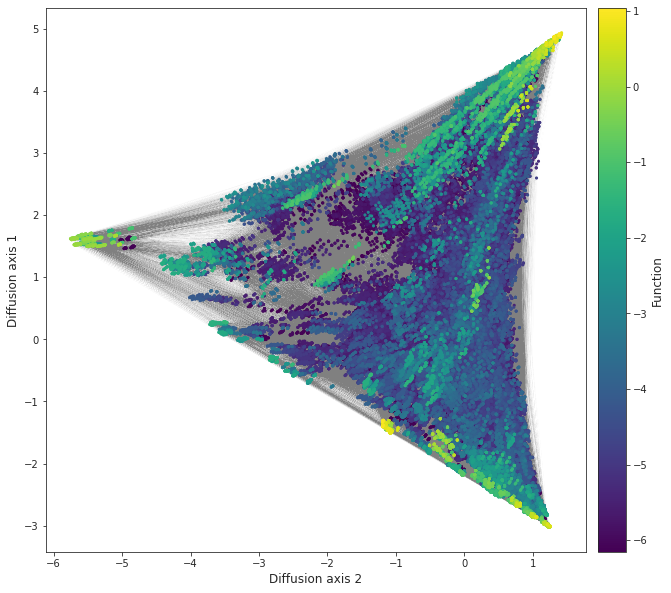

In [22]:
fig, axes = plot.init_fig(1, 1, figsize=(11, 10))
plot.plot_visualization(axes, nodes_df, edges_df=edges_df,
                        edges_alpha=0.005, ascending=True,
                        nodes_size=10, x='2', y='1')

### References

```{bibliography} path/to/references.bib
```
